In [ ]:
import os
from threadpoolctl import threadpool_limits
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Set environment variable to limit OpenBLAS threads
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# Load Data
def read(dataset, file):
    return pd.read_csv('mrs_challenge_data' + '/' + dataset + '.' + file, sep='\t')

users = read('lfm-challenge', 'user')
items = read('lfm-challenge', 'item')
train_inters = read('lfm-challenge', 'inter_train')
test_inters = read('lfm-challenge', 'inter_test')
musicnn_embedding = read('lfm-challenge', 'musicnn')
test_indices = pd.read_csv('mrs_challenge_data/test_indices.txt', sep='\t', header=None).squeeze()

# Concatenate train and test interactions
all_inters = pd.concat([train_inters, test_inters])

# Shuffle and split the interactions into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create Interaction Matrix
def inter_matr_implicit(users: pd.DataFrame, items: pd.DataFrame, interactions: pd.DataFrame) -> csr_matrix:
    user_to_index = {user_id: index for index, user_id in enumerate(users['user_id'])}
    item_to_index = {item_id: index for index, item_id in enumerate(items['item_id'])}
    num_users = len(users)
    num_items = len(items)
    interaction_matrix = np.zeros((num_users, num_items), dtype=np.float32)
    for _, row in interactions.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        count = row['count']
        if user_id in user_to_index and item_id in item_to_index:
            user_index = user_to_index[user_id]
            item_index = item_to_index[item_id]
            interaction_matrix[user_index, item_index] = count
    return csr_matrix(interaction_matrix)

# Function to evaluate nDCG
def evaluate_ndcg(recommendations, test_inter_matrix, k=10):
    ndcg_scores = []
    for user_id, recs in recommendations.items():
        if user_id >= test_inter_matrix.shape[0]:  # Skip invalid users
            continue
        true_relevance = test_inter_matrix.getrow(user_id).toarray().reshape(1, -1)
        scores = np.zeros(true_relevance.shape)
        scores[0, recs] = 1
        ndcg_scores.append(ndcg_score(true_relevance, scores, k=k))
    return np.mean(ndcg_scores)

# SVD Recommender
def svd_recommender(train_inter_matrix, k=10, num_factors=50):
    user_factors, item_factors, user_means = mean_centered_svd(train_inter_matrix, num_factors=num_factors)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        scores = np.dot(user_factors[user], item_factors.T) + user_means[user]
        recommendations[user] = [rec for rec in np.argsort(scores)[::-1][:k] if rec < num_items]
    return recommendations

# Mean Centered SVD
def mean_centered_svd(train_inter_matrix, num_factors=50):
    dense_matrix = train_inter_matrix.toarray()  # Convert sparse matrix to dense
    user_means = np.mean(dense_matrix, axis=1)
    centered_matrix = dense_matrix - user_means[:, np.newaxis]
    u, s, vt = svds(centered_matrix, k=num_factors)
    s = np.diag(s)
    user_factors = np.dot(u, s)
    item_factors = vt.T
    return user_factors, item_factors, user_means

# Random Recommender
# def random_recommender(train_inter_matrix, k=10):
#     recommendations = {}
#     num_items = train_inter_matrix.shape[1]
#     for user in range(train_inter_matrix.shape[0]):
#         seen_items = train_inter_matrix[user].nonzero()[1]
#         recs = np.random.choice(np.setdiff1d(np.arange(num_items), seen_items), size=k, replace=False)
#         recommendations[user] = recs
#     return recommendations
def random_recommender(train_inter_matrix, k=10):
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        recs = np.random.choice(np.setdiff1d(np.arange(num_items), seen_items), size=k, replace=False)
        recommendations[user] = recs
    return recommendations


# Popularity-based Recommender (Top-Pop)
# def pop_recommender(train_inter_matrix, k=10):
#     pop_scores = np.array(train_inter_matrix.sum(axis=0)).flatten()
#     top_items = np.argsort(pop_scores)[::-1]
#     recommendations = {}
#     for user in range(train_inter_matrix.shape[0]):
#         seen_items = train_inter_matrix[user].nonzero()[1]
#         recs = [item for item in top_items if item not in seen_items][:k]
#         recommendations[user] = recs
#     return recommendations

def pop_recommender(train_inter_matrix, k=10):
    pop_scores = np.array(train_inter_matrix.sum(axis=0)).flatten()
    top_items = np.argsort(pop_scores)[::-1]
    recommendations = {}
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        recs = [item for item in top_items if item not in seen_items][:k]
        recommendations[user] = recs
    return recommendations
# def pop_recommender(inter_matr: np.array,
#                user: int,
#                top_k: int) -> np.array:
    
#     top_pop = None
    
#     # Calculate item popularity as the sum of interactions across all users
#     item_popularity = inter_matr.sum(axis=0)
    
#     # Get the items the user has not seen (interacted with)
#     unseen_items = np.where(inter_matr[user] == 0)[0]
    
#     # Sort unseen items by popularity in descending order and select top K
#     top_pop = unseen_items[np.argsort(item_popularity[unseen_items])[::-1][:top_k]]
    
#     return top_pop.tolist()

    
    return top_pop

# Function to perform exhaustive grid search with cross-validation
def exhaustive_grid_search_svd_cv(interactions, users, items, k=10):
    results = []
    num_factors_options = [20, 50, 100, 150, 200, 250, 300, 350, 400]

    for num_factors in num_factors_options:
        fold_ndcg_scores = []
        for train_index, val_index in kf.split(interactions):
            train_inters = interactions.iloc[train_index]
            val_inters = interactions.iloc[val_index]
            train_matrix = inter_matr_implicit(users, items, train_inters)
            val_matrix = inter_matr_implicit(users, items, val_inters)
            
            svd_recommendations = svd_recommender(train_matrix, k=k, num_factors=num_factors)
            svd_ndcg = evaluate_ndcg(svd_recommendations, val_matrix, k)
            fold_ndcg_scores.append(svd_ndcg)
        
        mean_ndcg = np.mean(fold_ndcg_scores)
        results.append(('SVD', f'num_factors={num_factors}', mean_ndcg))
        print(f"num_factors: {num_factors}, mean_nDCG: {mean_ndcg}")
    
    return results

# After the exhaustive grid search, find the best parameters
def find_best_parameters(results_df):
    best_row = results_df.loc[results_df['nDCG'].idxmax()]
    best_parameters = best_row['Parameter']
    best_ndcg = best_row['nDCG']
    return best_parameters, best_ndcg

# Plotting the hyperparameter tuning results
def plot_hyperparameter_tuning_svd(svd_results_param,svd_results_nDCG):
    plt.figure(figsize=(14, 8))
    num_factors_options = svd_results_param
    palette = plt.get_cmap('tab10', len(num_factors_options))
    color_map = {num_factors: palette(i) for i, num_factors in enumerate(num_factors_options)}

    plt.scatter(svd_results_param,svd_results_nDCG, marker='o', color='b', label="num_factors")

    plt.xlabel('num_factors', fontsize=12)
    plt.ylabel('nDCG Score', fontsize=12)
    plt.title('Hyperparameter Tuning Results for SVD', fontsize=14)
    
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    # Setting up the x-axis ticks and labels
    plt.xticks(ticks=num_factors_options, labels=[str(num) for num in num_factors_options], rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Adding minor ticks
    plt.minorticks_on()
    plt.tick_params(axis='x', which='both', bottom=True, top=False)
    plt.tick_params(axis='y', which='both', left=True, right=False)
    
    # Improving the legend
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()

    plt.savefig('hyperparameter_tuning_svd.png', bbox_inches='tight')
    plt.savefig('hyperparameter_tuning_svd.pdf', bbox_inches='tight')
    plt.show()

# Evaluate random recommender
random_recommendations = random_recommender(inter_matr_implicit(users, items, all_inters))
random_ndcg = evaluate_ndcg(random_recommendations, inter_matr_implicit(users, items, all_inters))
print(f"Random Recommender nDCG: {random_ndcg}")

# Evaluate popularity-based recommender
pop_recommendations = pop_recommender(inter_matr_implicit(users, items, all_inters))
pop_ndcg = evaluate_ndcg(pop_recommendations, inter_matr_implicit(users, items, all_inters))
print(f"Popularity-based Recommender nDCG: {pop_ndcg}")    

# Run Exhaustive Grid Search with Cross-Validation for SVD
svd_results = exhaustive_grid_search_svd_cv(all_inters, users, items)
svd_results_df = pd.DataFrame(svd_results, columns=['Algorithm', 'Parameter', 'nDCG'])

# Print Results
print(svd_results_df)

# Find the best parameter setting
best_parameters, best_ndcg = find_best_parameters(svd_results_df)
print(f"Best Parameters: {best_parameters}, Best nDCG: {best_ndcg}")

# Plot the hyperparameter tuning results
svd_results_param = svd_results_df['Parameter'].apply(lambda x: int(x.split('=')[1].split(',')[0])).values
svd_results_nDCG = svd_results_df['nDCG'].values
plot_hyperparameter_tuning_svd(svd_results_param,svd_results_nDCG)



In [ ]:
svd_results_df.to_csv('hyperparameter_tuning_results_svd.csv', index=False)


# Applying weighted SVD

In [ ]:
# Weighted SVD
def weighted_svd(train_inter_matrix, num_factors=50, weights=15):
    dense_matrix = train_inter_matrix.toarray()  # Convert sparse matrix to dense
    user_means = np.mean(dense_matrix, axis=1)
    centered_matrix = dense_matrix - user_means[:, np.newaxis]
    
    # Create a weight matrix
    weight_matrix = np.ones(centered_matrix.shape) * weights
    weighted_matrix = centered_matrix * weight_matrix
    
    # Perform SVD
    u, s, vt = svds(weighted_matrix, k=num_factors)
    s = np.diag(s)
    user_factors = np.dot(u, s)
    item_factors = vt.T
    return user_factors, item_factors, user_means

# wSVD Recommender
def wsvd_recommender(train_inter_matrix, k=10, num_factors=50, weights=15):
    user_factors, item_factors, user_means = weighted_svd(train_inter_matrix, num_factors=num_factors, weights=weights)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        scores = np.dot(user_factors[user], item_factors.T) + user_means[user]
        recommendations[user] = [rec for rec in np.argsort(scores)[::-1][:k] if rec < num_items]
    return recommendations

# Function to perform exhaustive grid search with cross-validation
def exhaustive_grid_search_wsvd_cv(interactions, users, items, k=10):
    results = []
    num_factors_options = [200, 250, 300]
    weights_options = [1, 5, 10, 15, 20]

    for num_factors in num_factors_options:
        for weights in weights_options:
            fold_ndcg_scores = []
            for train_index, val_index in kf.split(interactions):
                train_inters = interactions.iloc[train_index]
                val_inters = interactions.iloc[val_index]
                train_matrix = inter_matr_implicit(users, items, train_inters)
                val_matrix = inter_matr_implicit(users, items, val_inters)
                
                wsvd_recommendations = wsvd_recommender(train_matrix, k=k, num_factors=num_factors, weights=weights)
                wsvd_ndcg = evaluate_ndcg(wsvd_recommendations, val_matrix, k)
                fold_ndcg_scores.append(wsvd_ndcg)
            
            mean_ndcg = np.mean(fold_ndcg_scores)
            results.append(('wSVD', f'num_factors={num_factors}, weights={weights}', mean_ndcg))
            print(f"num_factors: {num_factors}, weights: {weights}, mean_nDCG: {mean_ndcg}")
    
    return results

# Run Exhaustive Grid Search with Cross-Validation for SVD
wsvd_results = exhaustive_grid_search_wsvd_cv(all_inters, users, items)
wsvd_results_df = pd.DataFrame(svd_results, columns=['Algorithm', 'Parameter', 'nDCG'])

# Print Results
print(wsvd_results_df)

# Find the best parameter setting
best_parameters, best_ndcg = find_best_parameters(wsvd_results_df)
print(f"Best Parameters: {best_parameters}, Best nDCG: {best_ndcg}")



# Regularization in SVD

In [ ]:
# Enhanced SVD with Bias and Regularization
def enhanced_svd(train_inter_matrix, num_factors=50, regularization=0.1):
    dense_matrix = train_inter_matrix.toarray()  # Convert sparse matrix to dense
    user_means = np.mean(dense_matrix, axis=1)
    item_means = np.mean(dense_matrix, axis=0)
    global_mean = np.mean(dense_matrix)
    centered_matrix = dense_matrix - user_means[:, np.newaxis] - item_means[np.newaxis, :] + global_mean
    
    # Perform SVD
    u, s, vt = svds(centered_matrix, k=num_factors)
    s = np.diag(s + regularization)  # Apply regularization to the singular values
    user_factors = np.dot(u, s)
    item_factors = vt.T
    return user_factors, item_factors, user_means, item_means, global_mean

# Enhanced SVD Recommender
def enhanced_svd_recommender(train_inter_matrix, k=10, num_factors=50, regularization=0.1):
    user_factors, item_factors, user_means, item_means, global_mean = enhanced_svd(train_inter_matrix, num_factors=num_factors, regularization=regularization)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        scores = np.dot(user_factors[user], item_factors.T) + user_means[user] + item_means - global_mean
        recommendations[user] = [rec for rec in np.argsort(scores)[::-1][:k] if rec < num_items]
    return recommendations

# Function to perform exhaustive grid search with cross-validation
def exhaustive_grid_search_enhanced_svd_cv(interactions, users, items, k=10):
    results = []
    num_factors_options = [200, 250, 300]
    regularization_options = [0.01, 0.05, 0.1, 0.5, 1.0]

    for num_factors in num_factors_options:
        for regularization in regularization_options:
            fold_ndcg_scores = []
            for train_index, val_index in kf.split(interactions):
                train_inters = interactions.iloc[train_index]
                val_inters = interactions.iloc[val_index]
                train_matrix = inter_matr_implicit(users, items, train_inters)
                val_matrix = inter_matr_implicit(users, items, val_inters)
                
                enhanced_svd_recommendations = enhanced_svd_recommender(train_matrix, k=k, num_factors=num_factors, regularization=regularization)
                enhanced_svd_ndcg = evaluate_ndcg(enhanced_svd_recommendations, val_matrix, k)
                fold_ndcg_scores.append(enhanced_svd_ndcg)
            
            mean_ndcg = np.mean(fold_ndcg_scores)
            results.append(('Enhanced_SVD', f'num_factors={num_factors}, reg={regularization}', mean_ndcg))
            print(f"num_factors: {num_factors}, regularization: {regularization}, mean_nDCG: {mean_ndcg}")
    
    return results


# Plotting the hyperparameter tuning results
def plot_hyperparameter_tuning(results_df):
    plt.figure(figsize=(14, 8))
    parameters = results_df['Parameter'].apply(lambda x: tuple(map(float, x.replace('num_factors=', '').replace('reg=', '').split(', '))))
    num_factors_options = [param[0] for param in parameters]
    reg_options = [param[1] for param in parameters]
    ndcg_scores = results_df['nDCG']
    
    scatter = plt.scatter(num_factors_options, ndcg_scores, c=reg_options, cmap='viridis', marker='o')
    plt.colorbar(scatter, label='Regularization')
    
    plt.xlabel('num_factors', fontsize=12)
    plt.ylabel('nDCG Score', fontsize=12)
    plt.title('Hyperparameter Tuning Results for Enhanced SVD', fontsize=14)
    
    plt.xticks(num_factors_options, rotation=90)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=10)
    plt.tight_layout()
    
    plt.savefig('hyperparameter_tuning_enhanced_svd.png', bbox_inches='tight')
    plt.savefig('hyperparameter_tuning_enhanced_svd.pdf', bbox_inches='tight')
    plt.show()

# Run Exhaustive Grid Search with Cross-Validation for Enhanced SVD
enhanced_svd_results = exhaustive_grid_search_enhanced_svd_cv(all_inters, users, items)
enhanced_svd_results_df = pd.DataFrame(enhanced_svd_results, columns=['Algorithm', 'Parameter', 'nDCG'])

# Print Results
print(enhanced_svd_results_df)

# Find the best parameter setting
best_parameters, best_ndcg = find_best_parameters(enhanced_svd_results_df)
print(f"Best Parameters: {best_parameters}, Best nDCG: {best_ndcg}")

# Plot the hyperparameter tuning results
plot_hyperparameter_tuning(enhanced_svd_results_df)


 Applying feature engineering: using musicnn for additional features --> didn't work some errors due mismatch of dimensions

# Applying Item KNN
In Addition using Joblib to speed up computation.

In [ ]:
musicnn_embedding

num_neighbors=5, mean_nDCG: 0.04821451987747496
num_neighbors=10, mean_nDCG: 0.04509881770442087
num_neighbors=20, mean_nDCG: 0.043370414398411695
num_neighbors=30, mean_nDCG: 0.043689636158917154
num_neighbors=40, mean_nDCG: 0.04449067555082185
num_neighbors=50, mean_nDCG: 0.04521283428745382
num_neighbors=60, mean_nDCG: 0.04588681172721923
num_neighbors=70, mean_nDCG: 0.04615557279379622
  Algorithm         Parameter      nDCG
0   ItemKNN   num_neighbors=5  0.048215
1   ItemKNN  num_neighbors=10  0.045099
2   ItemKNN  num_neighbors=20  0.043370
3   ItemKNN  num_neighbors=30  0.043690
4   ItemKNN  num_neighbors=40  0.044491
5   ItemKNN  num_neighbors=50  0.045213
6   ItemKNN  num_neighbors=60  0.045887
7   ItemKNN  num_neighbors=70  0.046156
num_factors=20, mean_nDCG: 0.012555476658449525
num_factors=50, mean_nDCG: 0.019240401656589037
num_factors=100, mean_nDCG: 0.02369512527046197
num_factors=150, mean_nDCG: 0.028806806678378746
num_factors=200, mean_nDCG: 0.03130153634676249
num_fa

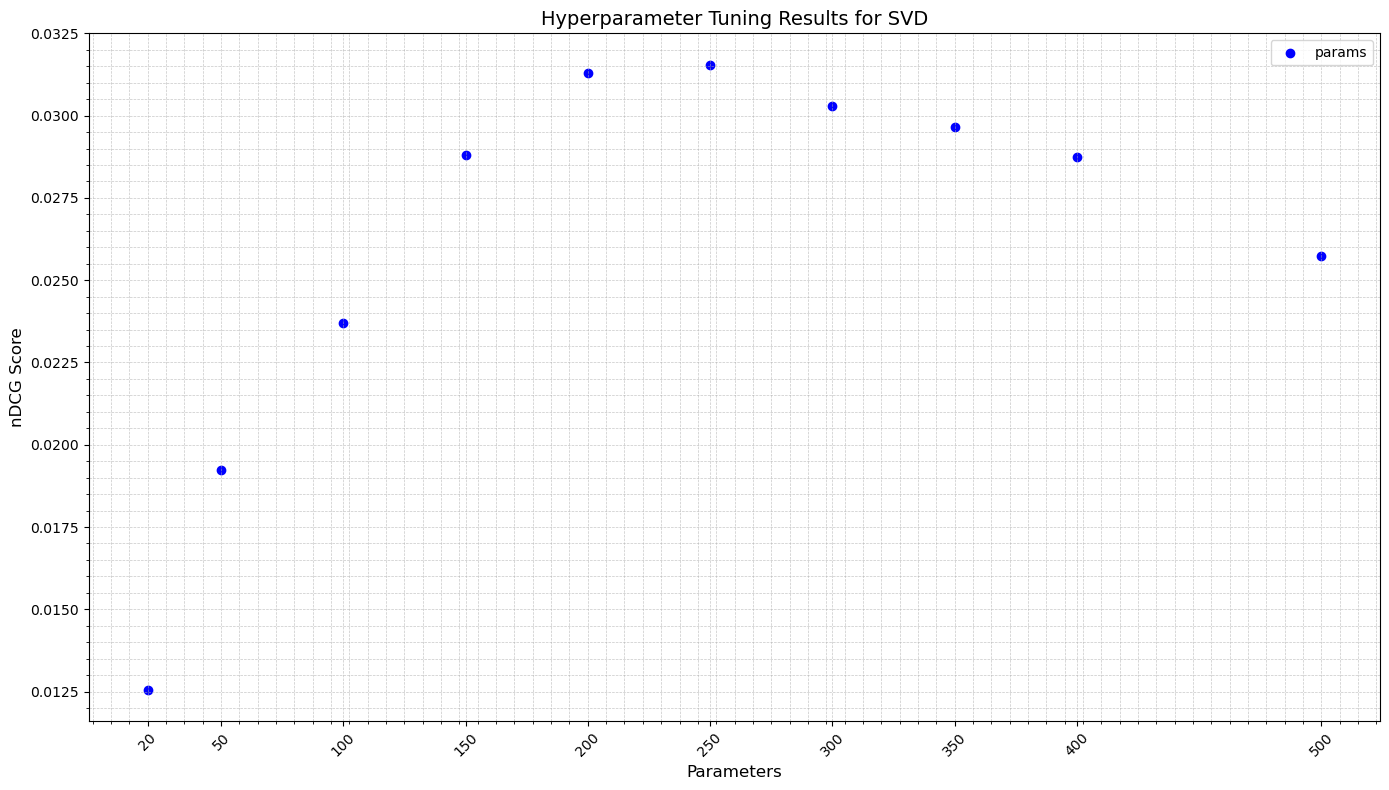

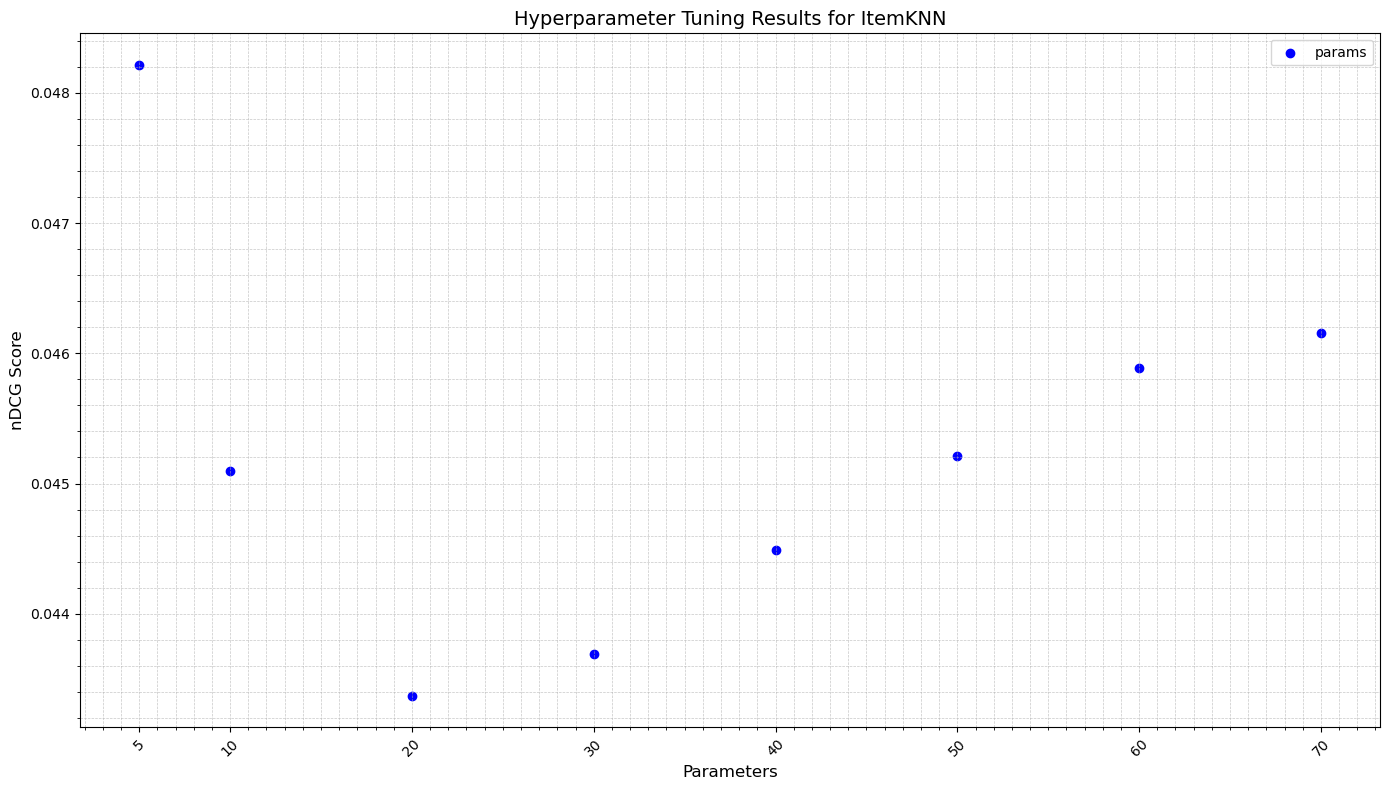

Random Recommender nDCG: 0.0
Random Recommender user nDCG scores:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 132: 0.0, 170: 0.0, 193: 0.0, 224: 0.0, 275

In [5]:
import os
from threadpoolctl import threadpool_limits
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from joblib import Parallel, delayed

# Set environment variable to limit OpenBLAS threads
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# Load Data
def read(dataset, file):
    return pd.read_csv(f'mrs_challenge_data/{dataset}.{file}', sep='\t')

users = read('lfm-challenge', 'user')
items = read('lfm-challenge', 'item')
train_inters = read('lfm-challenge', 'inter_train')
test_inters = read('lfm-challenge', 'inter_test')
musicnn_embedding = read('lfm-challenge', 'musicnn')
test_indices = pd.read_csv('mrs_challenge_data/test_indices.txt', sep='\t', header=None).squeeze()

# Convert test indices to integer array
test_user_ids = test_indices.iloc[1:].values.astype(int)

# Concatenate train and test interactions
all_inters = pd.concat([train_inters, test_inters])

# Shuffle and split the interactions into 3 folds for faster testing
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Create Interaction Matrix
def inter_matr_implicit(users: pd.DataFrame, items: pd.DataFrame, interactions: pd.DataFrame) -> csr_matrix:
    user_to_index = {user_id: index for index, user_id in enumerate(users['user_id'])}
    item_to_index = {item_id: index for index, item_id in enumerate(items['item_id'])}
    num_users = len(users)
    num_items = len(items)
    interaction_matrix = np.zeros((num_users, num_items), dtype=np.float32)
    for _, row in interactions.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        count = row['count']
        if user_id in user_to_index and item_id in item_to_index:
            user_index = user_to_index[user_id]
            item_index = item_to_index[item_id]
            interaction_matrix[user_index, item_index] = count
    return csr_matrix(interaction_matrix)
a
# Function to evaluate nDCG
def evaluate_ndcg(recommendations, test_inter_matrix, k=10, specific_users=None):
    ndcg_scores = []
    user_ndcg = {}
    if specific_users is not None:
        users = specific_users
    else:
        users = range(test_inter_matrix.shape[0])
    
    for user_id in users:
        if user_id >= test_inter_matrix.shape[0]:  # Skip invalid users
            continue
        recs = recommendations.get(user_id, [])
        true_relevance = test_inter_matrix.getrow(user_id).toarray().reshape(1, -1)
        scores = np.zeros(true_relevance.shape)
        scores[0, recs] = 1
        ndcg = ndcg_score(true_relevance, scores, k=k)
        ndcg_scores.append(ndcg)
        user_ndcg[user_id] = ndcg
    return np.mean(ndcg_scores), user_ndcg

# SVD Recommender
def svd_recommender(train_inter_matrix, k=10, num_factors=50):
    user_factors, item_factors, user_means = mean_centered_svd(train_inter_matrix, num_factors=num_factors)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        scores = np.dot(user_factors[user], item_factors.T) + user_means[user]
        recommendations[user] = [rec for rec in np.argsort(scores)[::-1][:k] if rec < num_items]
    return recommendations

# Mean Centered SVD
def mean_centered_svd(train_inter_matrix, num_factors=50):
    dense_matrix = train_inter_matrix.toarray()  # Convert sparse matrix to dense
    user_means = np.mean(dense_matrix, axis=1)
    centered_matrix = dense_matrix - user_means[:, np.newaxis]
    u, s, vt = svds(centered_matrix, k=num_factors)
    s = np.diag(s)
    user_factors = np.dot(u, s)
    item_factors = vt.T
    return user_factors, item_factors, user_means

# ItemKNN Recommender
def item_knn_recommender(train_inter_matrix, k=10, num_neighbors=5):
    item_similarity = cosine_similarity(train_inter_matrix.T)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        user_ratings = train_inter_matrix[user].toarray().flatten()
        # Consider only the top num_neighbors neighbors
        neighbors = np.argsort(item_similarity, axis=1)[:, :-num_neighbors-1:-1]
        scores = np.zeros(num_items)
        for item, neighbors in enumerate(neighbors):
            scores[item] = user_ratings[neighbors].dot(item_similarity[item, neighbors])
        top_recs = np.argsort(scores)[::-1]
        # Filter out items already seen by the user
        seen_items = user_ratings.nonzero()[0]
        top_recs = [rec for rec in top_recs if rec not in seen_items][:k]
        recommendations[user] = [rec for rec in top_recs if rec < num_items]
    return recommendations

# Random Recommender
def random_recommender(train_inter_matrix, k=10):
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        recs = np.random.choice(np.setdiff1d(np.arange(num_items), seen_items), size=k, replace=False)
        recommendations[user] = recs
    return recommendations

# Popularity-based Recommender (Top-Pop)
def pop_recommender(train_inter_matrix, k=10):
    pop_scores = np.array(train_inter_matrix.sum(axis=0)).flatten()
    top_items = np.argsort(pop_scores)[::-1]
    recommendations = {}
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        recs = [item for item in top_items if item not in seen_items][:k]
        recommendations[user] = recs
    return recommendations

# Function to perform exhaustive grid search with cross-validation for SVD
def exhaustive_grid_search_svd_cv(interactions, users, items, k=10):
    results = []
    num_factors_options = [20, 50, 100, 150, 200, 250, 300, 350, 400, 500]

    def svd_cv(num_factors):
        fold_ndcg_scores = []
        for train_index, val_index in kf.split(interactions):
            train_inters = interactions.iloc[train_index]
            val_inters = interactions.iloc[val_index]
            train_matrix = inter_matr_implicit(users, items, train_inters)
            val_matrix = inter_matr_implicit(users, items, val_inters)
            
            svd_recommendations = svd_recommender(train_matrix, k=k, num_factors=num_factors)
            svd_ndcg, _ = evaluate_ndcg(svd_recommendations, val_matrix, k)
            fold_ndcg_scores.append(svd_ndcg)
        
        mean_ndcg = np.mean(fold_ndcg_scores)
        return ('SVD', f'num_factors={num_factors}', mean_ndcg)
    
    results = Parallel(n_jobs=-1)(delayed(svd_cv)(num_factors) for num_factors in num_factors_options)
    for result in results:
        print(f"{result[1]}, mean_nDCG: {result[2]}")
    return results

# Function to perform exhaustive grid search with cross-validation for ItemKNN
def exhaustive_grid_search_itemknn_cv(interactions, users, items, k=10):
    results = []
    num_neighbors_options = [5, 10, 20, 30, 40, 50, 60, 70]

    def itemknn_cv(num_neighbors):
        fold_ndcg_scores = []
        for train_index, val_index in kf.split(interactions):
            train_inters = interactions.iloc[train_index]
            val_inters = interactions.iloc[val_index]
            train_matrix = inter_matr_implicit(users, items, train_inters)
            val_matrix = inter_matr_implicit(users, items, val_inters)
            
            itemknn_recommendations = item_knn_recommender(train_matrix, k=k, num_neighbors=num_neighbors)
            itemknn_ndcg, _ = evaluate_ndcg(itemknn_recommendations, val_matrix, k)
            fold_ndcg_scores.append(itemknn_ndcg)
        
        mean_ndcg = np.mean(fold_ndcg_scores)
        return ('ItemKNN', f'num_neighbors={num_neighbors}', mean_ndcg)
    
    results = Parallel(n_jobs=-1)(delayed(itemknn_cv)(num_neighbors) for num_neighbors in num_neighbors_options)
    for result in results:
        print(f"{result[1]}, mean_nDCG: {result[2]}")
    return results

# After the exhaustive grid search, find the best parameters
def find_best_parameters(results_df):
    best_row = results_df.loc[results_df['nDCG'].idxmax()]
    best_parameters = best_row['Parameter']
    best_ndcg = best_row['nDCG']
    return best_parameters, best_ndcg

# Plotting the hyperparameter tuning results
def plot_hyperparameter_tuning(results_df, algorithm):
    plt.figure(figsize=(8, 6))
    params = results_df['Parameter'].apply(lambda x: int(x.split('=')[1]))
    ndcg_scores = results_df['nDCG']
    
    plt.scatter(params, ndcg_scores, marker='o', color='b', label="params")
    
    plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('nDCG Score', fontsize=20)
    plt.title(f'Hyperparameter Tuning Results for {algorithm}', fontsize=14)
    
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    # Setting up the x-axis ticks and labels
    plt.xticks(ticks=params, labels=[str(param) for param in params], rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    
    # Adding minor ticks
    plt.minorticks_on()
    plt.tick_params(axis='x', which='both', bottom=True, top=False)
    plt.tick_params(axis='y', which='both', left=True, right=False)
    
    # Improving the legend
    plt.legend(loc='best', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()

    plt.savefig(f'hyperparameter_tuning_{algorithm}.png', bbox_inches='tight')
    plt.savefig(f'hyperparameter_tuning_{algorithm}.pdf', bbox_inches='tight')
    plt.show()

# Run Exhaustive Grid Search with Cross-Validation for ItemKNN
itemknn_results = exhaustive_grid_search_itemknn_cv(all_inters, users, items)
itemknn_results_df = pd.DataFrame(itemknn_results, columns=['Algorithm', 'Parameter', 'nDCG'])
print(itemknn_results_df)

# Run Exhaustive Grid Search with Cross-Validation for SVD
svd_results = exhaustive_grid_search_svd_cv(all_inters, users, items)
svd_results_df = pd.DataFrame(svd_results, columns=['Algorithm', 'Parameter', 'nDCG'])

# Print Results
print(svd_results_df)

# Find the best parameter settings
best_svd_parameters, best_svd_ndcg = find_best_parameters(svd_results_df)
best_itemknn_parameters, best_itemknn_ndcg = find_best_parameters(itemknn_results_df)
print(f"Best SVD Parameters: {best_svd_parameters}, Best nDCG: {best_svd_ndcg}")
print(f"Best ItemKNN Parameters: {best_itemknn_parameters}, Best nDCG: {best_itemknn_ndcg}")

# Plot the hyperparameter tuning results
plot_hyperparameter_tuning(svd_results_df, 'SVD')
plot_hyperparameter_tuning(itemknn_results_df, 'ItemKNN')

# Evaluate random recommender
random_recommendations = random_recommender(inter_matr_implicit(users, items, all_inters))
random_ndcg, random_user_ndcg = evaluate_ndcg(random_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
print(f"Random Recommender nDCG: {random_ndcg}")
print("Random Recommender user nDCG scores:")
print(random_user_ndcg)

# Evaluate popularity-based recommender
pop_recommendations = pop_recommender(inter_matr_implicit(users, items, all_inters))
pop_ndcg, pop_user_ndcg = evaluate_ndcg(pop_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
print(f"Popularity-based Recommender nDCG: {pop_ndcg}")
print("Popularity-based Recommender user nDCG scores:")
print(pop_user_ndcg)

# Generate Final Recommendations using the best models
final_svd_recommendations = svd_recommender(inter_matr_implicit(users, items, train_inters), k=10, num_factors=int(best_svd_parameters.split('=')[1]))
final_itemknn_recommendations = item_knn_recommender(inter_matr_implicit(users, items, train_inters), k=10, num_neighbors=int(best_itemknn_parameters.split('=')[1]))

# Format recommendations for submission
def format_recommendations(recommendations, test_indices):
    submission = []
    for user_ in test_indices[1:]:
        user = int(user_)
        submission.append(f"{user}\t{','.join(map(str, recommendations.get(user, [])))}")
    return submission

# Save final recommendations for SVD
svd_submission = format_recommendations(final_svd_recommendations, test_indices)
with open('rec_svd.tsv', 'w') as f:
    f.write('\n'.join(svd_submission))

# Save final recommendations for ItemKNN
itemknn_submission = format_recommendations(final_itemknn_recommendations, test_indices)
with open('rec_itemknn.tsv', 'w') as f:
    f.write('\n'.join(itemknn_submission))

# Compare final recommendations
print(f"Best SVD nDCG: {best_svd_ndcg}")
print(f"Best ItemKNN nDCG: {best_itemknn_ndcg}")
print(f"Random Recommender nDCG: {random_ndcg}")
print(f"Popularity-based Recommender nDCG: {pop_ndcg}")

# Hybrid Recommender
def hybrid_recommender(user, svd_recommendations, itemknn_recommendations, pop_recommendations, random_recommendations, threshold=0.5):
    # Choose the model with the highest nDCG for the user
    if random_user_ndcg.get(user, 0) < threshold and pop_user_ndcg.get(user, 0) < threshold:
        if random_user_ndcg.get(user, 0) > pop_user_ndcg.get(user, 0):
            return random_recommendations.get(user, [])
        else:
            return pop_recommendations.get(user, [])
    elif random_user_ndcg.get(user, 0) > pop_user_ndcg.get(user, 0):
        return svd_recommendations.get(user, [])
    else:
        return itemknn_recommendations.get(user, [])

# Generate hybrid recommendations for users in test_indices
hybrid_recommendations = {user: hybrid_recommender(user, final_svd_recommendations, final_itemknn_recommendations, pop_recommendations, random_recommendations) for user in test_user_ids}

# Save hybrid recommendations
hybrid_submission = format_recommendations(hybrid_recommendations, test_indices)
with open('rec_hybrid.tsv', 'w') as f:
    f.write('\n'.join(hybrid_submission))


In [8]:
# Function to evaluate nDCG
def evaluate_ndcg(recommendations, test_inter_matrix, k=10, specific_users=None):
    ndcg_scores = []
    user_ndcg = {}
    if specific_users is not None:
        users = specific_users
    else:
        users = range(test_inter_matrix.shape[0])
    
    for user_id in users:
        if user_id >= test_inter_matrix.shape[0]:  # Skip invalid users
            continue
        recs = recommendations.get(user_id, [])
        true_relevance = test_inter_matrix.getrow(user_id).toarray().reshape(1, -1)
        scores = np.zeros(true_relevance.shape)
        scores[0, recs] = 1
        ndcg = ndcg_score(true_relevance, scores, k=k)
        ndcg_scores.append(ndcg)
        user_ndcg[user_id] = ndcg
    return np.mean(ndcg_scores), user_ndcg

# Hybrid Recommender
def hybrid_recommender(user, svd_recommendations, itemknn_recommendations, pop_recommendations, random_recommendations, threshold=0.5):
    # Choose the model with the highest nDCG for the user
    svd_ndcg = svd_user_ndcg.get(user, 0)
    itemknn_ndcg = itemknn_user_ndcg.get(user, 0)
    pop_ndcg_user = pop_user_ndcg.get(user, 0)
    random_ndcg_user = random_user_ndcg.get(user, 0)

    if svd_ndcg >= max(itemknn_ndcg, pop_ndcg_user, random_ndcg_user):
        return svd_recommendations.get(user, [])
    elif itemknn_ndcg >= max(svd_ndcg, pop_ndcg_user, random_ndcg_user):
        return itemknn_recommendations.get(user, [])
    elif pop_ndcg_user >= max(svd_ndcg, itemknn_ndcg, random_ndcg_user):
        return pop_recommendations.get(user, [])
    else:
        return random_recommendations.get(user, [])

In [9]:
# Calculate nDCG scores for SVD and ItemKNN
_, svd_user_ndcg = evaluate_ndcg(final_svd_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
_, itemknn_user_ndcg = evaluate_ndcg(final_itemknn_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)

# Print nDCG scores for each user for SVD
print("SVD Recommender user nDCG scores:")
for user, ndcg in svd_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")

# Print nDCG scores for each user for ItemKNN
print("ItemKNN Recommender user nDCG scores:")
for user, ndcg in itemknn_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")

# Generate hybrid recommendations for users in test_indices
hybrid_recommendations = {user: hybrid_recommender(user, final_svd_recommendations, final_itemknn_recommendations, pop_recommendations, random_recommendations) for user in test_user_ids}

# Save hybrid recommendations
hybrid_submission = format_recommendations(hybrid_recommendations, test_indices)
with open('rec_hybrid.tsv', 'w') as f:
    f.write('\n'.join(hybrid_submission))

# Evaluate hybrid recommender
hybrid_ndcg, hybrid_user_ndcg = evaluate_ndcg(hybrid_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
print(f"Hybrid Recommender nDCG: {hybrid_ndcg}")
print("Hybrid Recommender user nDCG scores:")
print(hybrid_user_ndcg)


SVD Recommender user nDCG scores:
User 0: nDCG = 0.3453957166222713
User 1: nDCG = 0.0
User 2: nDCG = 0.4167895183641672
User 3: nDCG = 0.2785870653312153
User 4: nDCG = 0.547027471198223
User 5: nDCG = 0.17269785831113565
User 6: nDCG = 0.0
User 7: nDCG = 0.5079148666676166
User 8: nDCG = 0.0
User 9: nDCG = 0.1726978583111356
User 10: nDCG = 0.5286885925237707
User 11: nDCG = 0.0
User 12: nDCG = 0.35764836469388533
User 13: nDCG = 0.0
User 14: nDCG = 0.0
User 15: nDCG = 0.14511853333360478
User 16: nDCG = 0.43809662806838323
User 17: nDCG = 0.3453957166222713
User 18: nDCG = 0.0
User 19: nDCG = 0.0
User 20: nDCG = 0.0
User 21: nDCG = 0.0
User 22: nDCG = 0.27858706533121536
User 23: nDCG = 0.17269785831113565
User 24: nDCG = 0.0
User 25: nDCG = 0.0
User 26: nDCG = 0.0
User 27: nDCG = 0.3198293606680346
User 28: nDCG = 0.0
User 29: nDCG = 0.2785870653312153
User 30: nDCG = 0.0
User 31: nDCG = 0.0
User 32: nDCG = 0.5571741306624307
User 33: nDCG = 0.3453957166222713
User 34: nDCG = 0.0
U

Hybrid Recommender nDCG: 0.26081409318858034
Hybrid Recommender user nDCG scores:
{0: 0.3453957166222713, 1: 0.0, 2: 0.4167895183641672, 3: 0.2785870653312153, 4: 0.547027471198223, 5: 0.17269785831113565, 6: 0.0, 7: 0.5079148666676166, 8: 0.0, 9: 0.1726978583111356, 10: 0.5286885925237707, 11: 0.0, 12: 0.35764836469388533, 13: 0.2785870653312153, 14: 0.0, 15: 0.14511853333360478, 16: 0.43809662806838323, 17: 0.3453957166222713, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.27858706533121536, 23: 0.17269785831113565, 24: 0.0, 25: 0.0, 26: 0.17269785831113565, 27: 0.3198293606680346, 28: 0.0, 29: 0.2785870653312153, 30: 0.0, 31: 0.0, 32: 0.5571741306624307, 33: 0.3453957166222713, 34: 0.0, 35: 0.24518007143706608, 36: 0.3453957166222713, 37: 0.0, 38: 0.3453957166222712, 39: 0.21321957377868977, 40: 0.0, 41: 0.5571741306624307, 42: 0.3453957166222712, 43: 0.3453957166222712, 44: 0.27858706533121536, 45: 0.0, 46: 0.17269785831113565, 47: 0.43166032208866945, 48: 0.0, 49: 0.0, 50: 0.1654155827

In [10]:
# Calculate and print mean of hybrid_user_ndcg
mean_hybrid_ndcg = np.mean(list(hybrid_user_ndcg.values()))
print(f"Mean Hybrid Recommender nDCG: {mean_hybrid_ndcg}")

Mean Hybrid Recommender nDCG: 0.26081409318858034


In [12]:
mean_svd_ndcg = np.mean(list(svd_user_ndcg.values()))
print(f"Mean SVD Recommender nDCG: {mean_svd_ndcg}")

Mean SVD Recommender nDCG: 0.2566253262690447


In [13]:
mean_itemknn_ndcg = np.mean(list(itemknn_user_ndcg.values()))
print(f"Mean ItemKNN Recommender nDCG: {mean_itemknn_ndcg}")

Mean ItemKNN Recommender nDCG: 0.020538827894899518


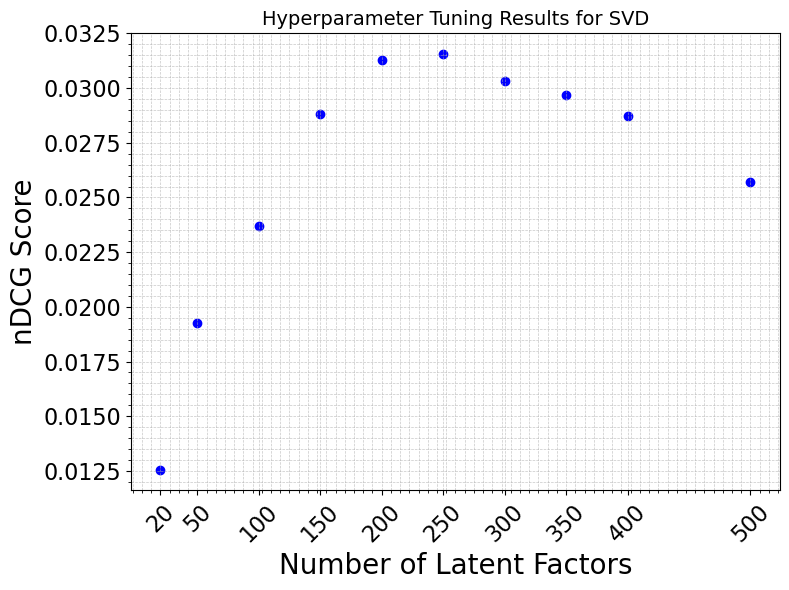

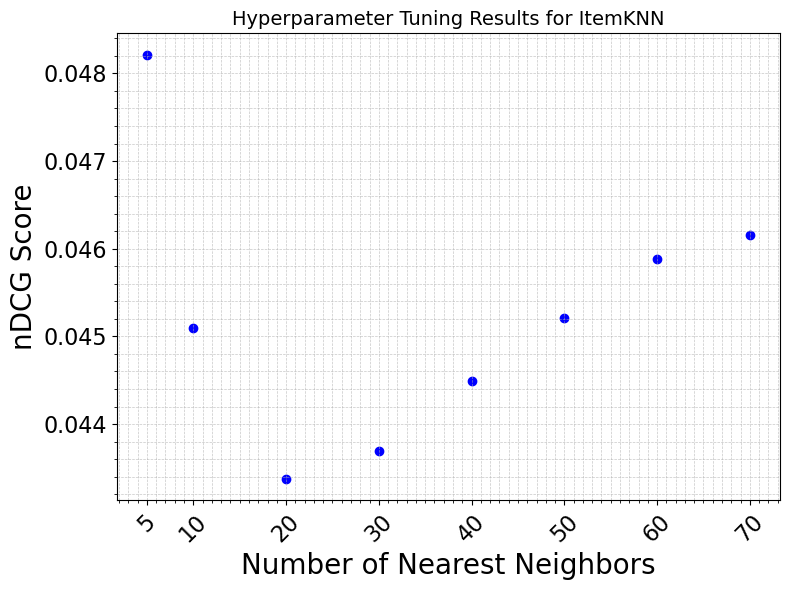

In [33]:
# Plotting the hyperparameter tuning results
def plot_hyperparameter_tuning(results_df, algorithm):
    plt.figure(figsize=(8, 6))
    params = results_df['Parameter'].apply(lambda x: int(x.split('=')[1]))
    ndcg_scores = results_df['nDCG']
    
    plt.scatter(params, ndcg_scores, marker='o', color='b', label="params")
    
    if algorithm=='SVD':
        plt.xlabel('Number of Latent Factors', fontsize=20)
    elif algorithm=='ItemKNN':
        plt.xlabel('Number of Nearest Neighbors', fontsize=20)
    else:
        plt.xlabel('Parameters', fontsize=20)
    plt.ylabel('nDCG Score', fontsize=20)
    plt.title(f'Hyperparameter Tuning Results for {algorithm}', fontsize=14)
    
#     plt.legend(loc='best', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    # Setting up the x-axis ticks and labels
    plt.xticks(ticks=params, labels=[str(param) for param in params], rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    
    # Adding minor ticks
    plt.minorticks_on()
    plt.tick_params(axis='x', which='both', bottom=True, top=False)
    plt.tick_params(axis='y', which='both', left=True, right=False)
    
    # Improving the legend
#     plt.legend(loc='best', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()

    plt.savefig(f'hyperparameter_tuning_{algorithm}.png', bbox_inches='tight')
    plt.savefig(f'hyperparameter_tuning_{algorithm}.pdf', bbox_inches='tight')
    plt.show()

# Plot the hyperparameter tuning results
plot_hyperparameter_tuning(svd_results_df, 'SVD')
plot_hyperparameter_tuning(itemknn_results_df, 'ItemKNN')

# New Working Pop Recommender

In [17]:
def pop_recommender(train_inter_matrix, k=10):
    # Calculate the popularity of each item (sum of interactions across all users)
    item_popularity = np.array(train_inter_matrix.sum(axis=0)).flatten()
    
    # Get the indices of items sorted by popularity (most popular first)
    top_items = np.argsort(item_popularity)[::-1]
    
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        # Recommend top k items that the user hasn't seen yet
        recs = [item for item in top_items if item not in seen_items][:k]
        recommendations[user] = recs
    
    return recommendations

# Evaluate the new popularity-based recommender
pop_recommendations = pop_recommender(inter_matr_implicit(users, items, train_inters), k=10)
pop_ndcg, pop_user_ndcg = evaluate_ndcg(pop_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)

print(f"New Popularity-based Recommender nDCG: {pop_ndcg}")
print("New Popularity-based Recommender user nDCG scores:")
for user, ndcg in pop_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")


New Popularity-based Recommender nDCG: 0.0011020842071571236
New Popularity-based Recommender user nDCG scores:
User 0: nDCG = 0.0
User 1: nDCG = 0.0
User 2: nDCG = 0.0
User 3: nDCG = 0.0
User 4: nDCG = 0.0
User 5: nDCG = 0.0
User 6: nDCG = 0.0
User 7: nDCG = 0.0
User 8: nDCG = 0.0
User 9: nDCG = 0.0
User 10: nDCG = 0.0
User 11: nDCG = 0.0
User 12: nDCG = 0.0
User 13: nDCG = 0.0
User 14: nDCG = 0.0
User 15: nDCG = 0.0
User 16: nDCG = 0.0
User 17: nDCG = 0.0
User 18: nDCG = 0.0
User 19: nDCG = 0.0
User 20: nDCG = 0.0
User 21: nDCG = 0.0
User 22: nDCG = 0.0
User 23: nDCG = 0.0
User 24: nDCG = 0.0
User 25: nDCG = 0.0
User 26: nDCG = 0.0
User 27: nDCG = 0.0
User 28: nDCG = 0.0
User 29: nDCG = 0.0
User 30: nDCG = 0.0
User 31: nDCG = 0.0
User 32: nDCG = 0.0
User 33: nDCG = 0.0
User 34: nDCG = 0.0
User 35: nDCG = 0.0
User 36: nDCG = 0.0
User 37: nDCG = 0.0
User 38: nDCG = 0.0
User 39: nDCG = 0.0
User 40: nDCG = 0.0
User 41: nDCG = 0.0
User 42: nDCG = 0.0
User 43: nDCG = 0.0
User 44: nDCG = 0.

# Improving ItemKNN

In [14]:
# Function to evaluate nDCG
def evaluate_ndcg(recommendations, test_inter_matrix, k=10, specific_users=None):
    ndcg_scores = []
    user_ndcg = {}
    if specific_users is not None:
        users = specific_users
    else:
        users = range(test_inter_matrix.shape[0])
    
    for user_id in users:
        if user_id >= test_inter_matrix.shape[0]:  # Skip invalid users
            continue
        recs = recommendations.get(user_id, [])
        if len(recs) == 0:  # Check if recommendations are empty
            print(f"No recommendations for user {user_id}")
        true_relevance = test_inter_matrix.getrow(user_id).toarray().reshape(1, -1)
        scores = np.zeros(true_relevance.shape)
        scores[0, recs] = 1
        ndcg = ndcg_score(true_relevance, scores, k=k)
        ndcg_scores.append(ndcg)
        user_ndcg[user_id] = ndcg
    return np.mean(ndcg_scores), user_ndcg

# Debugging function for ItemKNN
def item_knn_recommender(train_inter_matrix, k=10, num_neighbors=5):
    item_similarity = cosine_similarity(train_inter_matrix.T)
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        user_ratings = train_inter_matrix[user].toarray().flatten()
        if len(user_ratings.nonzero()[0]) == 0:
            print(f"User {user} has no interactions")
        # Consider only the top num_neighbors neighbors
        neighbors = np.argsort(item_similarity, axis=1)[:, :-num_neighbors-1:-1]
        scores = np.zeros(num_items)
        for item, neighbors in enumerate(neighbors):
            scores[item] = user_ratings[neighbors].dot(item_similarity[item, neighbors])
        top_recs = np.argsort(scores)[::-1]
        # Filter out items already seen by the user
        seen_items = user_ratings.nonzero()[0]
        top_recs = [rec for rec in top_recs if rec not in seen_items][:k]
        recommendations[user] = [rec for rec in top_recs if rec < num_items]
    return recommendations

# Evaluate nDCG for SVD and ItemKNN and print scores for each user
_, svd_user_ndcg = evaluate_ndcg(final_svd_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
_, itemknn_user_ndcg = evaluate_ndcg(final_itemknn_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)

# Print nDCG scores for each user for SVD
print("SVD Recommender user nDCG scores:")
for user, ndcg in svd_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")

# Print nDCG scores for each user for ItemKNN
print("ItemKNN Recommender user nDCG scores:")
for user, ndcg in itemknn_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")

# Calculate and print the mean of hybrid_user_ndcg
mean_hybrid_ndcg = np.mean(list(hybrid_user_ndcg.values()))
print(f"Mean Hybrid Recommender nDCG: {mean_hybrid_ndcg}")


SVD Recommender user nDCG scores:
User 0: nDCG = 0.3453957166222713
User 1: nDCG = 0.0
User 2: nDCG = 0.4167895183641672
User 3: nDCG = 0.2785870653312153
User 4: nDCG = 0.547027471198223
User 5: nDCG = 0.17269785831113565
User 6: nDCG = 0.0
User 7: nDCG = 0.5079148666676166
User 8: nDCG = 0.0
User 9: nDCG = 0.1726978583111356
User 10: nDCG = 0.5286885925237707
User 11: nDCG = 0.0
User 12: nDCG = 0.35764836469388533
User 13: nDCG = 0.0
User 14: nDCG = 0.0
User 15: nDCG = 0.14511853333360478
User 16: nDCG = 0.43809662806838323
User 17: nDCG = 0.3453957166222713
User 18: nDCG = 0.0
User 19: nDCG = 0.0
User 20: nDCG = 0.0
User 21: nDCG = 0.0
User 22: nDCG = 0.27858706533121536
User 23: nDCG = 0.17269785831113565
User 24: nDCG = 0.0
User 25: nDCG = 0.0
User 26: nDCG = 0.0
User 27: nDCG = 0.3198293606680346
User 28: nDCG = 0.0
User 29: nDCG = 0.2785870653312153
User 30: nDCG = 0.0
User 31: nDCG = 0.0
User 32: nDCG = 0.5571741306624307
User 33: nDCG = 0.3453957166222713
User 34: nDCG = 0.0
U

In [15]:
interaction_counts = train_inters['user_id'].value_counts()
print(interaction_counts.describe())


count    2795.000000
mean       27.141324
std        20.577239
min         1.000000
25%        15.000000
50%        21.000000
75%        32.000000
max       204.000000
Name: count, dtype: float64


In [16]:
from sklearn.preprocessing import normalize

def item_knn_recommender(train_inter_matrix, k=10, num_neighbors=5):
    item_similarity = cosine_similarity(train_inter_matrix.T)
    item_similarity = normalize(item_similarity, norm='l2')  # Normalize similarity
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        user_ratings = train_inter_matrix[user].toarray().flatten()
        if len(user_ratings.nonzero()[0]) == 0:
            print(f"User {user} has no interactions")
        # Consider only the top num_neighbors neighbors
        neighbors = np.argsort(item_similarity, axis=1)[:, :-num_neighbors-1:-1]
        scores = np.zeros(num_items)
        for item, neighbors in enumerate(neighbors):
            scores[item] = user_ratings[neighbors].dot(item_similarity[item, neighbors])
        top_recs = np.argsort(scores)[::-1]
        # Filter out items already seen by the user
        seen_items = user_ratings.nonzero()[0]
        top_recs = [rec for rec in top_recs if rec not in seen_items][:k]
        recommendations[user] = [rec for rec in top_recs if rec < num_items]
    return recommendations


### For users with no interactions or very few interactions, use a popularity-based recommender as a fallback.

In [34]:
def inter_matr_implicit(users: pd.DataFrame, items: pd.DataFrame, interactions: pd.DataFrame) -> csr_matrix:
    user_to_index = {user_id: index for index, user_id in enumerate(users['user_id'])}
    item_to_index = {item_id: index for index, item_id in enumerate(items['item_id'])}
    num_users = len(users)
    num_items = len(items)
    interaction_matrix = np.zeros((num_users, num_items), dtype=np.float32)
    for _, row in interactions.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        count = row['count']
        if user_id in user_to_index and item_id in item_to_index:
            user_index = user_to_index[user_id]
            item_index = item_to_index[item_id]
            interaction_matrix[user_index, item_index] = count
    return csr_matrix(interaction_matrix)

# Shuffle and split the interactions into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_ndcg(recommendations, test_inter_matrix, k=10, specific_users=None):
    ndcg_scores = []
    user_ndcg = {}
    if specific_users is not None:
        users = specific_users
    else:
        users = range(test_inter_matrix.shape[0])
    
    for user_id in users:
        if user_id >= test_inter_matrix.shape[0]:  # Skip invalid users
            continue
        recs = recommendations.get(user_id, [])
        true_relevance = test_inter_matrix.getrow(user_id).toarray().reshape(1, -1)
        scores = np.zeros(true_relevance.shape)
        scores[0, recs] = 1
        ndcg = ndcg_score(true_relevance, scores, k=k)
        ndcg_scores.append(ndcg)
        user_ndcg[user_id] = ndcg
    return np.mean(ndcg_scores), user_ndcg


def item_knn_with_fallback(train_inter_matrix, pop_recommendations, k=10, num_neighbors=5):
    item_similarity = cosine_similarity(train_inter_matrix.T)
    item_similarity = normalize(item_similarity, norm='l2')
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        user_ratings = train_inter_matrix[user].toarray().flatten()
        if len(user_ratings.nonzero()[0]) == 0:
            recommendations[user] = pop_recommendations[user]  # Use popularity-based recommendations
            continue
        neighbors = np.argsort(item_similarity, axis=1)[:, :-num_neighbors-1:-1]
        scores = np.zeros(num_items)
        for item, neighbors in enumerate(neighbors):
            scores[item] = user_ratings[neighbors].dot(item_similarity[item, neighbors])
        top_recs = np.argsort(scores)[::-1]
        seen_items = user_ratings.nonzero()[0]
        top_recs = [rec for rec in top_recs if rec not in seen_items][:k]
        recommendations[user] = [rec for rec in top_recs if rec < num_items]
    return recommendations

# Function to perform exhaustive grid search with cross-validation for ItemKNN
def exhaustive_grid_search_itemknn_cv(interactions, pop_recommendations, users, items, neighbors_list, k=10):
    results = []
    num_neighbors_options = neighbors_list #[4, 5, 6, 7]

    def itemknn_cv(num_neighbors):
        fold_ndcg_scores = []
        for train_index, val_index in kf.split(interactions):
            train_inters = interactions.iloc[train_index]
            val_inters = interactions.iloc[val_index]
            train_matrix = inter_matr_implicit(users, items, train_inters)
            val_matrix = inter_matr_implicit(users, items, val_inters)
            
            itemknn_recommendations = item_knn_with_fallback(train_matrix, pop_recommendations, k=k, num_neighbors=num_neighbors)
            itemknn_ndcg, _ = evaluate_ndcg(itemknn_recommendations, val_matrix, k)
            fold_ndcg_scores.append(itemknn_ndcg)
        
        mean_ndcg = np.mean(fold_ndcg_scores)
        return ('ItemKNN', f'num_neighbors={num_neighbors}', mean_ndcg)
    
    results = Parallel(n_jobs=-1)(delayed(itemknn_cv)(num_neighbors) for num_neighbors in num_neighbors_options)
    for result in results:
        print(f"{result[1]}, mean_nDCG: {result[2]}")
    return results

# # Generate popularity-based recommendations
# pop_recommendations = pop_recommender(inter_matr_implicit(users, items, train_inters), k=10)

# Run Exhaustive Grid Search with Cross-Validation for ItemKNN
itemknn_fallback_results = exhaustive_grid_search_itemknn_cv(all_inters, pop_recommendations, users, items,neighbors_list=[4,5,6,7])
itemknn_fallback_results_df = pd.DataFrame(itemknn_fallback_results, columns=['Algorithm', 'Parameter', 'nDCG'])
print(itemknn_fallback_results_df)

num_neighbors=4, mean_nDCG: 0.05428237430058377
num_neighbors=5, mean_nDCG: 0.05162812763461485
num_neighbors=6, mean_nDCG: 0.050318856246381126
num_neighbors=7, mean_nDCG: 0.050349169390480564
  Algorithm        Parameter      nDCG
0   ItemKNN  num_neighbors=4  0.054282
1   ItemKNN  num_neighbors=5  0.051628
2   ItemKNN  num_neighbors=6  0.050319
3   ItemKNN  num_neighbors=7  0.050349


In [36]:
# Find the best parameter settings
best_itemknn_fallback_parameters, best_fallback_itemknn_ndcg = find_best_parameters(itemknn_fallback_results_df)
print(f"Best ItemKNN Parameters: {best_itemknn_fallback_parameters}, Best nDCG: {best_fallback_itemknn_ndcg}")

Best ItemKNN Parameters: num_neighbors=4, Best nDCG: 0.05428237430058377


In [37]:
# Generate item-knn recommendations with fallback
final_itemknn_fallback_recommendations = item_knn_with_fallback(inter_matr_implicit(users, items, train_inters), pop_recommendations, k=10, num_neighbors=int(best_itemknn_fallback_parameters.split('=')[1]))

itemknn_ndcg, itemknn_user_ndcg = evaluate_ndcg(final_itemknn_fallback_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)

# Print nDCG scores for each user for ItemKNN
print("ItemKNN Recommender user nDCG scores after improvement:")
for user, ndcg in itemknn_user_ndcg.items():
    print(f"User {user}: nDCG = {ndcg}")
print("itemknn_ndcg:",itemknn_ndcg)


ItemKNN Recommender user nDCG scores after improvement:
User 0: nDCG = 0.0
User 1: nDCG = 0.0
User 2: nDCG = 0.0
User 3: nDCG = 0.0
User 4: nDCG = 0.29593289425477637
User 5: nDCG = 0.0
User 6: nDCG = 0.0
User 7: nDCG = 0.0
User 8: nDCG = 0.0
User 9: nDCG = 0.0
User 10: nDCG = 0.3272834144194771
User 11: nDCG = 0.0
User 12: nDCG = 0.0
User 13: nDCG = 0.0
User 14: nDCG = 0.0
User 15: nDCG = 0.0
User 16: nDCG = 0.0
User 17: nDCG = 0.0
User 18: nDCG = 0.0
User 19: nDCG = 0.0
User 20: nDCG = 0.0
User 21: nDCG = 0.0
User 22: nDCG = 0.0
User 23: nDCG = 0.0
User 24: nDCG = 0.0
User 25: nDCG = 0.0
User 26: nDCG = 0.17269785831113565
User 27: nDCG = 0.0
User 28: nDCG = 0.0
User 29: nDCG = 0.0
User 30: nDCG = 0.0
User 31: nDCG = 0.0
User 32: nDCG = 0.27858706533121536
User 33: nDCG = 0.0
User 34: nDCG = 0.0
User 35: nDCG = 0.0
User 36: nDCG = 0.0
User 37: nDCG = 0.0
User 38: nDCG = 0.1726978583111356
User 39: nDCG = 0.0
User 40: nDCG = 0.0
User 41: nDCG = 0.27858706533121536
User 42: nDCG = 0.0


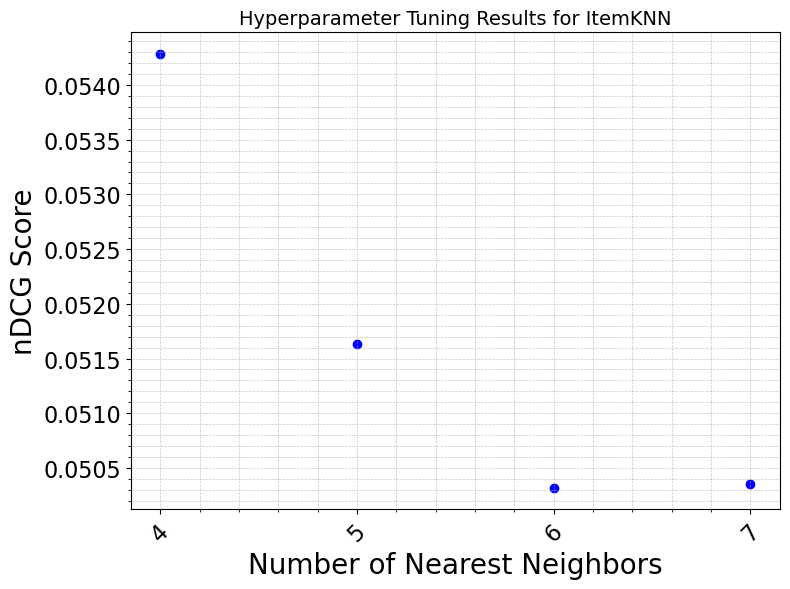

In [38]:
plot_hyperparameter_tuning(itemknn_fallback_results_df, 'ItemKNN')

In [40]:
mean_itemknn_ndcg = np.mean(list(itemknn_user_ndcg.values()))
print(f"Mean ItemKNN Recommender nDCG: {mean_itemknn_ndcg}")

Mean ItemKNN Recommender nDCG: 0.02033862596977438


In [43]:
# Run Exhaustive Grid Search with Cross-Validation for ItemKNN again
itemknn_fallback_results_b = exhaustive_grid_search_itemknn_cv(all_inters, pop_recommendations, users, items,neighbors_list=[3,4,15,16])
itemknn_fallback_results_df_b = pd.DataFrame(itemknn_fallback_results_b, columns=['Algorithm', 'Parameter', 'nDCG'])
print(itemknn_fallback_results_df_b)

num_neighbors=3, mean_nDCG: 0.05540301017560414
num_neighbors=4, mean_nDCG: 0.05428237430058377
num_neighbors=15, mean_nDCG: 0.049040106027204065
num_neighbors=16, mean_nDCG: 0.04923382526406033
  Algorithm         Parameter      nDCG
0   ItemKNN   num_neighbors=3  0.055403
1   ItemKNN   num_neighbors=4  0.054282
2   ItemKNN  num_neighbors=15  0.049040
3   ItemKNN  num_neighbors=16  0.049234


In [39]:
# Save final recommendations for ItemKNN
itemknn_submission = format_recommendations(final_itemknn_fallback_recommendations, test_indices)
with open('rec_itemknn_fallback.tsv', 'w') as f:
    f.write('\n'.join(itemknn_submission))

## Random Recommender updated

The issue of the `random_recommender` producing zero nDCG scores for test users could be due to several reasons, such as:
1. The recommendations are not relevant to the test users.
2. The test interactions might not have enough diversity or density to produce meaningful nDCG scores.

Here's an enhanced version of the `random_recommender` function with additional checks:

1. Ensure the random recommender does not recommend already seen items.
2. Handle edge cases where the user has seen all items.
3. Verify that the test interaction matrix is properly utilized for evaluation.

### Key Points to Check:
1. **Interaction Matrix Construction**: Ensure the interaction matrix correctly reflects user-item interactions.
2. **Test Set Relevance**: Confirm the test interactions contain relevant items that can produce meaningful nDCG scores.
3. **Diversity in Recommendations**: Random recommendations should cover a broad range of items to ensure relevance.

### Additional Debugging Steps:
1. **Print Recommendations**: Print out some of the recommendations to manually verify their relevance.
2. **Check Test Interactions**: Print and inspect the test interaction matrix to ensure it is correctly populated.

In [24]:
def random_recommender(train_inter_matrix, k=10):
    recommendations = {}
    num_items = train_inter_matrix.shape[1]
    for user in range(train_inter_matrix.shape[0]):
        seen_items = train_inter_matrix[user].nonzero()[1]
        available_items = np.setdiff1d(np.arange(num_items), seen_items)
        if len(available_items) >= k:
            recs = np.random.choice(available_items, size=k, replace=False)
        else:
            recs = np.random.choice(available_items, size=min(k, len(available_items)), replace=False)
        recommendations[user] = recs
    return recommendations

# Evaluate random recommender with new implementation
random_recommendations = random_recommender(inter_matr_implicit(users, items, all_inters))
random_ndcg, random_user_ndcg = evaluate_ndcg(random_recommendations, inter_matr_implicit(users, items, test_inters), specific_users=test_user_ids)
print(f"Random Recommender nDCG: {random_ndcg}")
print("Random Recommender user nDCG scores:")
print(random_user_ndcg)

# Print some recommendations for debugging
for user in test_user_ids[:5]:  # Print recommendations for the first 5 test users
    print(f"User {user} recommendations: {random_recommendations.get(user, [])}")

# Print some test interactions for debugging
print("Test interactions for first 5 test users:")
print(inter_matr_implicit(users, items, test_inters)[test_user_ids[:5]].toarray())


Random Recommender nDCG: 0.0
Random Recommender user nDCG scores:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 132: 0.0, 170: 0.0, 193: 0.0, 224: 0.0, 275

# Hybrid recommender

In [25]:
# Hybrid Recommender
def hybrid_recommender(user, svd_recommendations, itemknn_recommendations, pop_recommendations, random_recommendations, threshold=0.5):
    # Choose the model with the highest nDCG for the user
    svd_ndcg = svd_user_ndcg.get(user, 0)
    itemknn_ndcg = itemknn_user_ndcg.get(user, 0)
    pop_ndcg_user = pop_user_ndcg.get(user, 0)
    random_ndcg_user = random_user_ndcg.get(user, 0)

    if svd_ndcg >= max(itemknn_ndcg, pop_ndcg_user, random_ndcg_user):
        return svd_recommendations.get(user, [])
    elif itemknn_ndcg >= max(svd_ndcg, pop_ndcg_user, random_ndcg_user):
        return itemknn_recommendations.get(user, [])
    elif pop_ndcg_user >= max(svd_ndcg, itemknn_ndcg, random_ndcg_user):
        return pop_recommendations.get(user, [])
    else:
        return random_recommendations.get(user, [])

In [26]:
# Generate hybrid recommendations for users in test_indices
hybrid_recommendations = {user: hybrid_recommender(user, final_svd_recommendations, final_itemknn_recommendations, pop_recommendations, random_recommendations) for user in test_user_ids}

# Save hybrid recommendations
hybrid_submission = format_recommendations(hybrid_recommendations, test_indices)
with open('rec_hybrid.tsv', 'w') as f:
    f.write('\n'.join(hybrid_submission))

# Evaluate hybrid recommender
hybrid_ndcg, hybrid_user_ndcg = evaluate_ndcg(hybrid_recommendations, inter_matr_implicit(users, items, all_inters), specific_users=test_user_ids)
print(f"Hybrid Recommender nDCG: {hybrid_ndcg}")
print("Hybrid Recommender user nDCG scores:")
print(hybrid_user_ndcg)

Hybrid Recommender nDCG: 0.2601776595003138
Hybrid Recommender user nDCG scores:
{0: 0.3453957166222713, 1: 0.0, 2: 0.4167895183641672, 3: 0.2785870653312153, 4: 0.547027471198223, 5: 0.17269785831113565, 6: 0.0, 7: 0.5079148666676166, 8: 0.0, 9: 0.1726978583111356, 10: 0.5286885925237707, 11: 0.0, 12: 0.35764836469388533, 13: 0.2785870653312153, 14: 0.0, 15: 0.14511853333360478, 16: 0.43809662806838323, 17: 0.3453957166222713, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.27858706533121536, 23: 0.17269785831113565, 24: 0.0, 25: 0.0, 26: 0.17269785831113565, 27: 0.3198293606680346, 28: 0.0, 29: 0.2785870653312153, 30: 0.0, 31: 0.0, 32: 0.5571741306624307, 33: 0.3453957166222713, 34: 0.0, 35: 0.24518007143706608, 36: 0.3453957166222713, 37: 0.0, 38: 0.3453957166222712, 39: 0.21321957377868977, 40: 0.0, 41: 0.5571741306624307, 42: 0.3453957166222712, 43: 0.3453957166222712, 44: 0.27858706533121536, 45: 0.0, 46: 0.17269785831113565, 47: 0.43166032208866945, 48: 0.0, 49: 0.0, 50: 0.16541558277